# MLitw2

## Imports

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from sklearn import model_selection
from sklearn import linear_model
from sklearn import ensemble
from sklearn import neural_network
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
import shap
shap.initjs()

## Context

A marketplace is being attacked by bots that produce fake clicks and leads. The
marketplace reputation might be affected if sellers get tons of fake leads and receive
spam from bots. On top of that, these bots introduce noise to our models in
production that rely on user behavioural data. We need to save [COMPANY]'s reputation
detecting these fake users.
To do so, we have a dataset of logs of a span of five minutes. Each entry contains
the user id (UserId), the action that a user made (Event), the category it interacted
with (Category) and a column (Fake) indicating if that user is fake (1 is fake, 0 is a
real user).

In [2]:
train_set = pd.read_csv('../data/fake_users.csv', index_col=0)

In [3]:
train_set.head()

,UserId,Event,Category,Fake
0,F7A7BF3761,click_carrousel,Phone,0
1,BA8F7A71E6,send_sms,Motor,0
2,21C64F22FC,send_email,Jobs,0
3,F9E0306603,send_sms,Jobs,0
4,1B2143BACC,click_ad,Phone,0


In [4]:
train_set.dtypes

UserId      object
Event       object
Category    object
Fake         int64
dtype: object

An internal team in [COMPANY] studied the behaviour of these bots and concluded that:
- A bot tends to produce more clicks in an a window period of time than a real user

In [5]:
train_set.loc[train_set.Event.isin(['click_ad', 'click_carrousel']), ['UserId', 'Fake']].groupby(
    ['UserId']).value_counts().reset_index().rename(columns={0: 'count'}).groupby(['Fake'])[
    'count'].mean()

Fake
0     7.224645
1    15.843333
Name: count, dtype: float64

- The distribution of clicks for a given bot tends to be skewed towards clicks like click_ad and send_email, because the former can bias our algorithms and the latter aims to annoy our sellers.

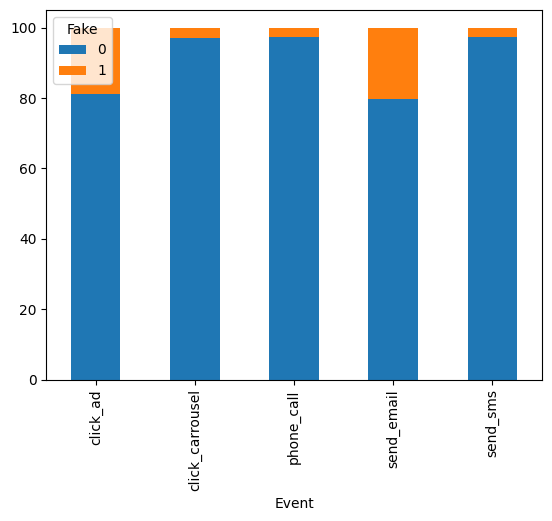

In [6]:
train_set.groupby(['Event'])[['Fake']].value_counts(normalize=True).mul(100).unstack().plot.bar(stacked=True);

- While real users interact with just a small subset of categories in a window time, bots behaviour are not centered into specific categories and interact with a vast majority of them.

In [7]:
train_set[['UserId', 'Category', 'Fake']].groupby(
    ['UserId', 'Fake'])['Category'].nunique().groupby('Fake').mean()

Fake
0    2.524
1    5.290
Name: Category, dtype: float64

## Instructions

- Your task is to create code that :
    - takes as input another .csv file with the same structure (but without the “Fake” columns)
    - outputs a .csv file with 2 columns : “UserId” and “is_fake_probability”
    - recommend a threshold to use for classification
- Programming language : Python is recommended, Scala is accepted
- Please submit a running piece of code, documented as you please (in the
code, separate docs, document by tests, whatever makes the code
understandable, exploration code)
- We are interested in 2 main aspects, in order of importance:
    - Production code quality : project structure, tests... The code should
also run on different platforms (Linux, macOS, …)
    - ML knowledge : feature engineering, model training and evaluation. You
can use any ML library you want. We are not looking for cutting edge
algorithms, don’t worry if the results are sub-optimal
- If you have ideas on how to improve the solution further, please write that
down as well
- Spend approximately 3 hours on the task

## Exploration: feature engineering

We want a prediction for each user, so we need to aggregate the dataset such that we have one sample per user.

From the indications, it seems we have to create at least three features: number of occurences in "click" events, number of occurences in "click_ad" and "send_email" events, and number of categories visited.

Two subsequent obvious features would be the number of lines per user, i.e. total time spent on the site, and most frequent event and category.

Lastly, an intuitive feature would be how often the category is changed, e.g. I can interact with only 3 categories but change my category every 5-minutes sample, or I can interact with 5 categories but moments apart.

In [8]:
def number_of_clicks(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return the number of clicks per user on the whole set

    :param pandas.DataFrame df: per user per timeframe dataframe with events
    :rtype: pandas.DataFrame
    """
    return df.loc[df.Event.isin(['click_ad', 'click_carrousel']), ['UserId',]].groupby(
        ['UserId']).value_counts().reset_index()[['UserId', 0]].rename(columns={0: 'number_clicks'}).set_index(
        'UserId')

In [9]:
number_of_clicks(train_set)

,number_clicks
UserId,
00079D439D,8
0007A4D4AE,12
000AFE2623,7
001A5362BC,6
0025995AF5,11
...,...
FFB0AC6E49,6
FFC56B0CDD,10
FFD2B9DC06,9


In [10]:
def ad_email(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return the number of click_ad and send_email per user on the whole set

    :param pandas.DataFrame df: per user per timeframe dataframe with events
    :rtype: pandas.DataFrame
    """
    return df.loc[df.Event.isin(['click_ad', 'send_email']), ['UserId']].groupby(
        ['UserId']).value_counts().reset_index()[['UserId', 0]].rename(columns={
        0: 'ad_email'}).set_index('UserId')

In [11]:
ad_email(train_set)

,ad_email
UserId,
00079D439D,9
0007A4D4AE,8
000AFE2623,7
001A5362BC,8
0025995AF5,7
...,...
FFB0AC6E49,9
FFC56B0CDD,19
FFD2B9DC06,8


In [12]:
def number_of_categories(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return the number of number_of_categories per user on the whole set

    :param pandas.DataFrame df: per user per timeframe dataframe with categories
    :rtype: pandas.DataFrame
    """
    return df[['Category', 'UserId']].groupby(['UserId']).nunique().rename(
        columns={'Category': 'n_categories'})

In [13]:
number_of_categories(train_set)

,n_categories
UserId,
00079D439D,2
0007A4D4AE,2
000AFE2623,4
001A5362BC,2
0025995AF5,5
...,...
FFB0AC6E49,3
FFC56B0CDD,5
FFD2B9DC06,1


In [14]:
def total_time(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return the total_time per user on the whole set

    :param pandas.DataFrame df: per user per timeframe dataframe
    :rtype: pandas.DataFrame
    """
    return df.groupby('UserId').size().reset_index().set_index('UserId').rename(columns={0: 'total_time'})

In [15]:
total_time(train_set)

,total_time
UserId,
00079D439D,19
0007A4D4AE,20
000AFE2623,21
001A5362BC,16
0025995AF5,21
...,...
FFB0AC6E49,18
FFC56B0CDD,24
FFD2B9DC06,20


In [19]:
def most_frequent(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return the most frequent event and category per user

    :param pandas.DataFrame df: per user per timeframe dataframe
    :rtype: pandas.DataFrame
    """
    return df.groupby('UserId')[['Event', 'Category']].agg(lambda x: pd.Series.mode(x)[0])

In [20]:
most_frequent(train_set)

,Event,Category
UserId,,
00079D439D,click_ad,Phone
0007A4D4AE,click_carrousel,Phone
000AFE2623,send_sms,Holidays
001A5362BC,send_email,Leisure
0025995AF5,click_carrousel,Phone
...,...,...
FFB0AC6E49,click_ad,Leisure
FFC56B0CDD,send_email,Motor
FFD2B9DC06,click_carrousel,Leisure


In [21]:
def n_changes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return the number of changes of category per user

    :param pandas.DataFrame df: per user per timeframe dataframe
    :rtype: pandas.DataFrame
    """
    usergroups = df.groupby('UserId')['Category']
    return pd.DataFrame.from_dict({user: sum((1 for i, x in enumerate(chunk.values[:-1]) if x != chunk.values[i + 1]))
                         for user, chunk in usergroups}, orient='index').rename(columns={0: 'n_changes'})

In [22]:
n_changes(train_set)

,n_changes
00079D439D,2
0007A4D4AE,2
000AFE2623,6
001A5362BC,2
0025995AF5,11
...,...
FFB0AC6E49,4
FFC56B0CDD,19
FFD2B9DC06,0
FFDF962B04,6


## Exploitation

In [23]:
engineered_set = pd.concat([number_of_clicks(train_set),
                            ad_email(train_set),
                            number_of_categories(train_set),
                            total_time(train_set),
                            most_frequent(train_set),
                            n_changes(train_set),
                            train_set.groupby('UserId')['Fake'].first().to_frame()],
                           axis=1)

In [24]:
engineered_set.head()

,number_clicks,ad_email,n_categories,total_time,Event,Category,n_changes,Fake
00079D439D,8.0,9,2,19,click_ad,Phone,2,0
0007A4D4AE,12.0,8,2,20,click_carrousel,Phone,2,0
000AFE2623,7.0,7,4,21,send_sms,Holidays,6,0
001A5362BC,6.0,8,2,16,send_email,Leisure,2,0
0025995AF5,11.0,7,5,21,click_carrousel,Phone,11,0


`number_clicks` and `ad_email` can return NaNs since we select on events. We can fill with 0s.

In [25]:
engineered_set.fillna(0, inplace=True)

Since the test set can be "shallower" than the training set (i.e. less timeframes), let's normalize by the number of observed timeframes per user.

In [26]:
engineered_set[["number_clicks", "ad_email", "n_categories", "n_changes"]] = engineered_set[
    ["number_clicks", "ad_email", "n_categories", "n_changes"]].div(engineered_set["total_time"], axis=0)

In [27]:
engineered_set.drop('total_time', axis=1, inplace=True)

In [28]:
engineered_set.head()

,number_clicks,ad_email,n_categories,Event,Category,n_changes,Fake
00079D439D,0.421053,0.473684,0.105263,click_ad,Phone,0.105263,0
0007A4D4AE,0.600000,0.400000,0.100000,click_carrousel,Phone,0.100000,0
000AFE2623,0.333333,0.333333,0.190476,send_sms,Holidays,0.285714,0
001A5362BC,0.375000,0.500000,0.125000,send_email,Leisure,0.125000,0
0025995AF5,0.523810,0.333333,0.238095,click_carrousel,Phone,0.523810,0


## Final model

In [29]:
engineered_set

,number_clicks,ad_email,n_categories,Event,Category,n_changes,Fake
00079D439D,0.421053,0.473684,0.105263,click_ad,Phone,0.105263,0
0007A4D4AE,0.600000,0.400000,0.100000,click_carrousel,Phone,0.100000,0
000AFE2623,0.333333,0.333333,0.190476,send_sms,Holidays,0.285714,0
001A5362BC,0.375000,0.500000,0.125000,send_email,Leisure,0.125000,0
0025995AF5,0.523810,0.333333,0.238095,click_carrousel,Phone,0.523810,0
...,...,...,...,...,...,...,...
FFC56B0CDD,0.416667,0.791667,0.208333,send_email,Motor,0.791667,1
FFD2B9DC06,0.450000,0.400000,0.050000,click_carrousel,Leisure,0.000000,0
FFDF962B04,0.333333,0.333333,0.266667,send_sms,Phone,0.400000,0
FFFDC1CD0F,0.526316,0.315789,0.105263,click_carrousel,Motor,0.105263,0


In [36]:
enc = OneHotEncoder()
enc.fit(engineered_set)

engineered_set_object = engineered_set.select_dtypes('object')
enc.fit(engineered_set_object)
codes = enc.transform(engineered_set_object).toarray()
feature_names = enc.get_feature_names_out()

X = pd.concat([engineered_set.select_dtypes(exclude='object'), 
               pd.DataFrame(codes, columns=feature_names, index=engineered_set.index).astype(int)], axis=1)

In [37]:
X

,number_clicks,ad_email,n_categories,n_changes,Fake,Event_click_ad,Event_click_carrousel,Event_phone_call,Event_send_email,Event_send_sms,Category_Holidays,Category_Jobs,Category_Leisure,Category_Motor,Category_Phone,Category_Real_State
00079D439D,0.421053,0.473684,0.105263,0.105263,0,1,0,0,0,0,0,0,0,0,1,0
0007A4D4AE,0.600000,0.400000,0.100000,0.100000,0,0,1,0,0,0,0,0,0,0,1,0
000AFE2623,0.333333,0.333333,0.190476,0.285714,0,0,0,0,0,1,1,0,0,0,0,0
001A5362BC,0.375000,0.500000,0.125000,0.125000,0,0,0,0,1,0,0,0,1,0,0,0
0025995AF5,0.523810,0.333333,0.238095,0.523810,0,0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FFC56B0CDD,0.416667,0.791667,0.208333,0.791667,1,0,0,0,1,0,0,0,0,1,0,0
FFD2B9DC06,0.450000,0.400000,0.050000,0.000000,0,0,1,0,0,0,0,0,1,0,0,0
FFDF962B04,0.333333,0.333333,0.266667,0.400000,0,0,0,0,0,1,0,0,0,0,1,0
FFFDC1CD0F,0.526316,0.315789,0.105263,0.105263,0,0,1,0,0,0,0,0,0,1,0,0


In [84]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X.drop('Fake', axis=1), engineered_set['Fake'], test_size=0.2)

In [85]:
y_train.sum()  # slightly unbalanced

246

In [88]:
engineered_set['Fake'].sum() / len(engineered_set['Fake'])

0.05660377358490566

In [89]:
models_to_try = {
    'Logistic Regression': sk.linear_model.LogisticRegression(),
    'AdaBoost': sk.ensemble.AdaBoostClassifier(),
    'Neural net': sk.neural_network.MLPClassifier(early_stopping=True)
}
params = {
    'Logistic Regression': {
        'C': np.linspace(10e-4, 10e4, 3),
        'penalty': ['l1'],
        'solver': ['saga']
    },
    'SVM': {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'class_weight': [None, 'balanced']
    },
    'Gradient Boosting': {
        'learning_rate': np.linspace(10e-4, 10e-2, 3)
    },
    'AdaBoost': {
        'n_estimators': [100],
        'learning_rate': [0.9]
    },
    'Neural net': {
        'hidden_layer_sizes': [(200, 100, ), (100, 50, 30, )],
        'solver': ['adam'],
    }
}
common_params = {
    'n_jobs': 3,
    'verbose': 3,
    'error_score': 'raise',
    'cv': sk.model_selection.StratifiedKFold()
}

In [90]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [91]:
gridsearchs = {}
for model in models_to_try.keys():
    gridsearchs.setdefault(model, sk.model_selection.GridSearchCV(
        estimator=models_to_try[model],
        param_grid=params[model],
        **common_params).fit(X_train, y_train))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: Convergence

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does 

/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does 

/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does 

/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/adrien/.local/share/virtualenvs/MLitw2-g1-MIUKt/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does 

In [92]:
cv_results = [gridsearch.cv_results_ for gridsearch in gridsearchs.values()]
bests = [gridsearch.best_index_ for gridsearch in gridsearchs.values()]
best = np.argmax([cv_result['mean_test_score'][bests[index]] for index, cv_result in enumerate(cv_results)])
gridsearch = list(gridsearchs.values())[best]
best_cv_result = cv_results[best]
best_index = bests[best]

In [93]:
cv_results

[{'mean_fit_time': array([0.01438308, 0.12497859, 0.13263073]),
  'std_fit_time': array([0.00150406, 0.0005044 , 0.00529682]),
  'mean_score_time': array([0.00124068, 0.00118361, 0.00143151]),
  'std_score_time': array([1.53521231e-04, 4.34072699e-05, 1.52787019e-04]),
  'param_C': masked_array(data=[0.001, 50000.000499999995, 100000.0],
               mask=[False, False, False],
         fill_value='?',
              dtype=object),
  'param_penalty': masked_array(data=['l1', 'l1', 'l1'],
               mask=[False, False, False],
         fill_value='?',
              dtype=object),
  'param_solver': masked_array(data=['saga', 'saga', 'saga'],
               mask=[False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'C': 0.001, 'penalty': 'l1', 'solver': 'saga'},
   {'C': 50000.000499999995, 'penalty': 'l1', 'solver': 'saga'},
   {'C': 100000.0, 'penalty': 'l1', 'solver': 'saga'}],
  'split0_test_score': array([0.5       , 0.99937422, 0.99937422]),

In [94]:
gridsearch

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise', estimator=LogisticRegression(), n_jobs=3,
             param_grid={'C': array([1.00000000e-03, 5.00000005e+04, 1.00000000e+05]),
                         'penalty': ['l1'], 'solver': ['saga']},
             verbose=3)

In [95]:
gridsearch.best_estimator_

LogisticRegression(C=50000.000499999995, penalty='l1', solver='saga')

Logistic Regression is the best model.

In [96]:
gridsearch.best_estimator_.coef_

array([[-3.71576499, 20.03063122, -9.90018592, 30.8083509 , -2.75984457,
        -5.77238973, -5.22697837, -3.37652085, -3.56785956, -3.08064123,
        -3.6100102 , -3.48894881, -2.87826077, -4.20361918, -3.44131789]])

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


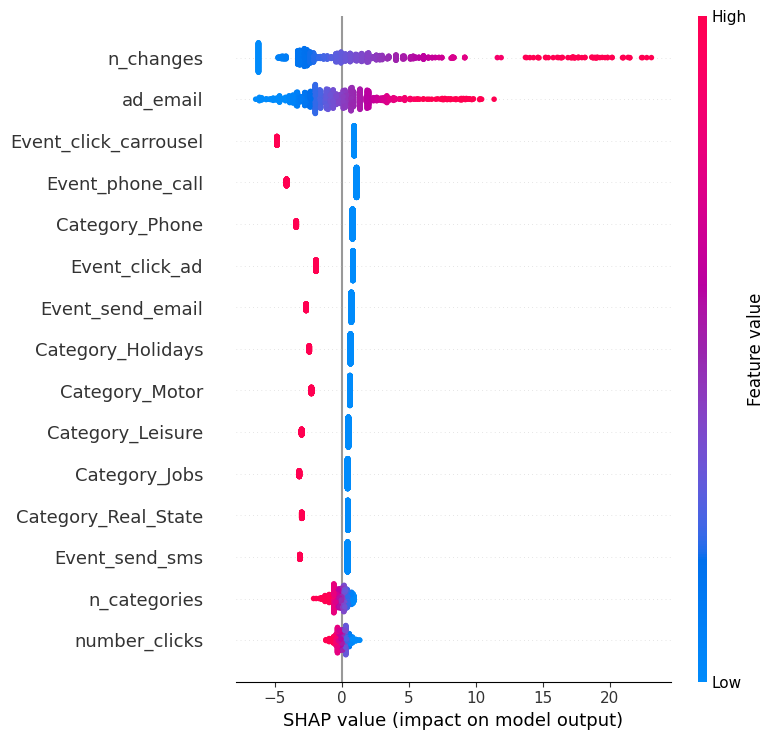

In [97]:
explainer = shap.LinearExplainer(model=gridsearch.best_estimator_,
                                 data=X_test,
                                 feature_dependence="independent",
                                 masker=shap.maskers.Independent(data=X_test))
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_train.columns.to_list())

In [98]:
print(sk.metrics.classification_report(y_test, gridsearch.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1006
           1       0.98      1.00      0.99        54

    accuracy                           1.00      1060
   macro avg       0.99      1.00      1.00      1060
weighted avg       1.00      1.00      1.00      1060



In [100]:
gridsearch.best_estimator_.predict_proba(X_test)

array([[7.09306911e-07, 9.99999291e-01],
       [9.99999947e-01, 5.27710674e-08],
       [9.99999793e-01, 2.06666721e-07],
       ...,
       [9.99999985e-01, 1.52342026e-08],
       [1.00000000e+00, 8.21185155e-12],
       [9.99999983e-01, 1.70213395e-08]])

## Pickling

In [80]:
import pickle
with open("encoder", "wb") as f: 
    pickle.dump(enc, f)

In [81]:
with open("model", "wb") as f: 
    pickle.dump(gridsearch.best_estimator_, f)

## Test

In [109]:
test_set = pd.read_csv('../data/fake_users_test.csv')

In [110]:
engineered_test_set = pd.concat([number_of_clicks(test_set),
                            ad_email(test_set),
                            number_of_categories(test_set),
                            total_time(test_set),
                            most_frequent(test_set),
                            n_changes(test_set),
                            test_set.groupby('UserId')['Fake'].first().to_frame()],
                           axis=1)

In [111]:
engineered_test_set[["number_clicks", "ad_email", "n_categories", "n_changes"]] = engineered_test_set[
    ["number_clicks", "ad_email", "n_categories", "n_changes"]].div(engineered_test_set["total_time"], axis=0)
engineered_test_set.drop('total_time', axis=1, inplace=True)

In [112]:
engineered_test_set_object = engineered_test_set[['Event', 'Category']]
codes = enc.transform(engineered_test_set_object).toarray()
feature_names = enc.get_feature_names_out()

X = pd.concat([engineered_test_set[["number_clicks", "ad_email", "n_categories", "n_changes"]],
               pd.DataFrame(codes, columns=feature_names, index=engineered_test_set.index).astype(int)], axis=1)

In [113]:
X

,number_clicks,ad_email,n_categories,n_changes,Event_click_ad,Event_click_carrousel,Event_phone_call,Event_send_email,Event_send_sms,Category_Holidays,Category_Jobs,Category_Leisure,Category_Motor,Category_Phone,Category_Real_State
02B1149F07T,0.437500,0.125000,0.187500,0.187500,0,1,0,0,0,0,0,0,1,0,0
03E7EE785DT,0.333333,0.400000,0.333333,0.400000,0,0,1,0,0,0,0,0,0,1,0
09F94548B6T,0.400000,0.533333,0.066667,0.000000,1,0,0,0,0,0,0,0,1,0,0
0AA15A16ECT,0.500000,0.300000,0.150000,0.250000,0,1,0,0,0,0,0,0,1,0,0
0BADFD7019T,0.421053,0.421053,0.105263,0.210526,0,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F866660C47T,0.470588,0.411765,0.058824,0.000000,0,1,0,0,0,0,0,0,0,0,1
F8B01BC688T,0.437500,0.437500,0.062500,0.000000,1,0,0,0,0,0,1,0,0,0,0
F9D53E8A10T,0.333333,0.428571,0.190476,0.380952,0,0,0,1,0,0,0,0,0,0,1
FCE3B5A371T,0.500000,0.500000,0.250000,0.375000,1,0,0,0,0,0,1,0,0,0,0


In [114]:
predictions = gridsearch.best_estimator_.predict_proba(X)[:, 1]

In [115]:
predictions

array([2.15698860e-11, 5.91153163e-07, 1.84360928e-08, 5.66013049e-09,
       3.95806888e-08, 1.61613022e-07, 1.19854422e-08, 1.72256379e-08,
       1.09580941e-09, 3.21557129e-07, 1.73752910e-06, 6.22334858e-10,
       2.38401310e-05, 6.24680594e-08, 9.19525007e-05, 2.46882420e-10,
       8.58929527e-09, 5.46280865e-07, 6.63250726e-05, 1.02092055e-07,
       9.99747218e-01, 1.18984946e-07, 3.14935342e-08, 1.19550369e-07,
       4.78761156e-08, 1.25412195e-05, 1.28736131e-07, 1.43300831e-07,
       1.94561544e-06, 2.11174770e-07, 5.97160684e-11, 4.39584183e-08,
       1.15037350e-06, 5.55065732e-08, 7.82271000e-11, 1.31148004e-08,
       3.99365473e-09, 1.74327888e-06, 3.32529552e-10, 2.13614296e-07,
       9.98847119e-13, 1.44740333e-07, 1.82226666e-10, 9.99977526e-01,
       1.28427548e-06, 7.82392082e-10, 8.78562579e-10, 4.65532708e-07,
       2.92695878e-09, 1.24687096e-08, 9.03941927e-08, 2.92145994e-07,
       3.47281230e-08, 4.42318163e-09, 3.10750392e-08, 4.29933011e-12,
      